# Imports

In [20]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import io
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.figure import Figure
import vcf

Example Input: /Users/davidchen/Documents/COVID-19_Mutation_signature/Clade_Analysis

In [2]:
directory = input("Print the full file path of your local directory to the Clade Analysis Folder: ")

Print the full file path of your local directory to the Clade Analysis Folder: /Users/davidchen/Documents/COVID-19_Mutation_signature/Clade_Analysis


# Settings

In [11]:
#pd.set_option('display.max_columns', None)  
#pd.set_option('display.max_rows', None)  
#pd.set_option('display.max_colwidth', 500)
plt.style.use('ggplot') 

# NC_045512 Genome Annotation

In [4]:
url = 'https://raw.githubusercontent.com/davidchen0420/Mutation_Signature/main/GCF_009858895.2_ASM985889v3_genomic.gff'
GFF3 = pd.read_csv(
    filepath_or_buffer=url, 
    sep='\t', 
    header=None,
    names=['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'],
    skiprows=[i for i in range(25)])

GFF = GFF3[GFF3['source'].notnull()]
GFF_sorted = GFF.sort_values(by ='start')


In [5]:
#Remove stem loop
GFF_sorted = GFF_sorted[GFF_sorted['type'] != "stem_loop"]
#Remove duplicates 
GFF_sorted = GFF_sorted.drop_duplicates(subset='start', keep="first")
#Reset index
GFF_sorted.reset_index(inplace=True, drop=True)
#Genomic elements from annotation
product_list = ["ORF1a","nsp2", "nsp3", "nps4", "nps5", "nps6", "nps7", "nps8", 
                "nps9", "nps10", "nps11", "3'to 5' exonuclease", "EndoRNAse", 
                "2'-O ribose methyltransferase", "Spike Glycoprotein", "ORF3a",
                "E", "M", "ORF6", "ORF7a", "ORF7b", "ORF8", "N", "ORF10", "3' UTR"]
#Add known genomic elements to dataframe
GFF_sorted['element'] = product_list

Elements of the Reference Genome Annotation

In [6]:
#Take a look at the genomic elements in the reference COVID-19 sequence
GFF_sorted

,seqid,source,type,start,end,score,strand,phase,attributes,element
0,NC_045512.2,RefSeq,CDS,266.0,13483.0,.,+,0,"ID=cds-YP_009725295.1;Parent=gene-GU280_gp01;Dbxref=Genbank:YP_009725295.1,GeneID:43740578;Name=YP_009725295.1;Note=pp1a;gbkey=CDS;gene=ORF1ab;locus_tag=GU280_gp01;product=ORF1a polyprotein;protein_id=YP_009725295.1",ORF1a
1,NC_045512.2,RefSeq,mature_protein_region_of_CDS,806.0,2719.0,.,+,.,ID=id-YP_009725295.1:181..818;Note=produced by both pp1a and pp1ab;Parent=cds-YP_009725295.1;gbkey=Prot;product=nsp2;protein_id=YP_009742609.1,nsp2
2,NC_045512.2,RefSeq,mature_protein_region_of_CDS,2720.0,8554.0,.,+,.,ID=id-YP_009725295.1:819..2763;Note=former nsp1%3B conserved domains are: N-terminal acidic (Ac)%2C predicted phosphoesterase%2C papain-like proteinase%2C Y-domain%2C transmembrane domain 1 (TM1)%2C adenosine diphosphate-ribose 1''-phosphatase (ADRP)%3B produced by both pp1a and pp1ab;Parent=cds-YP_009725295.1;gbkey=Prot;product=nsp3;protein_id=YP_009742610.1,nsp3
3,NC_045512.2,RefSeq,mature_protein_region_of_CDS,8555.0,10054.0,.,+,.,ID=id-YP_009725295.1:2764..3263;Note=nsp4B_TM%3B contains transmembrane domain 2 (TM2)%3B produced by both pp1a and pp1ab;Parent=cds-YP_009725295.1;gbkey=Prot;product=nsp4;protein_id=YP_009742611.1,nps4
4,NC_045512.2,RefSeq,mature_protein_region_of_CDS,10055.0,10972.0,.,+,.,ID=id-YP_009725295.1:3264..3569;Note=nsp5A_3CLpro and nsp5B_3CLpro%3B main proteinase (Mpro)%3B mediates cleavages downstream of nsp4. 3D structure of the SARSr-CoV homolog has been determined (Yang et al.%2C 2003)%3B produced by both pp1a and pp1ab;Parent=cds-YP_009725295.1;gbkey=Prot;product=3C-like proteinase;protein_id=YP_009742612.1,nps5
5,NC_045512.2,RefSeq,mature_protein_region_of_CDS,10973.0,11842.0,.,+,.,ID=id-YP_009725295.1:3570..3859;Note=nsp6_TM%3B putative transmembrane domain%3B produced by both pp1a and pp1ab;Parent=cds-YP_009725295.1;gbkey=Prot;product=nsp6;protein_id=YP_009742613.1,nps6
6,NC_045512.2,RefSeq,mature_protein_region_of_CDS,11843.0,12091.0,.,+,.,ID=id-YP_009725295.1:3860..3942;Note=produced by both pp1a and pp1ab;Parent=cds-YP_009725295.1;gbkey=Prot;product=nsp7;protein_id=YP_009742614.1,nps7
7,NC_045512.2,RefSeq,mature_protein_region_of_CDS,12092.0,12685.0,.,+,.,ID=id-YP_009725295.1:3943..4140;Note=produced by both pp1a and pp1ab;Parent=cds-YP_009725295.1;gbkey=Prot;product=nsp8;protein_id=YP_009742615.1,nps8
8,NC_045512.2,RefSeq,mature_protein_region_of_CDS,12686.0,13024.0,.,+,.,ID=id-YP_009725295.1:4141..4253;Note=ssRNA-binding protein%3B produced by both pp1a and pp1ab;Parent=cds-YP_009725295.1;gbkey=Prot;product=nsp9;protein_id=YP_009742616.1,nps9
9,NC_045512.2,RefSeq,mature_protein_region_of_CDS,13025.0,13441.0,.,+,.,ID=id-YP_009725295.1:4254..4392;Note=nsp10_CysHis%3B formerly known as growth-factor-like protein (GFL)%3B produced by both pp1a and pp1ab;Parent=cds-YP_009725295.1;gbkey=Prot;product=nsp10;protein_id=YP_009742617.1,nps10


# Read a VCF as a Pandas dataframe

In [7]:
def read_vcf(clade):
    with open(directory + "/" + str(clade) + "_snps.vcf", 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})

Example: Read in first 5 sequences of the Clade O variants VCF file.

Not recommended to load and view the entire vcf file at once using the current implementation of the read_vcf function. May lead to memory overusage.

In [63]:
clade_O = read_vcf(clade="O")
clade_O.head(5)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NC_045512.2,hCoV-19/USA/IL1/2020|EPI_ISL_404253|2020-01-21,hCoV-19/Taiwan/2/2020|EPI_ISL_406031|2020-01-23,hCoV-19/USA/CA2/2020|EPI_ISL_406036|2020-01-22,hCoV-19/Singapore/5/2020|EPI_ISL_410536|2020-02-06,hCoV-19/Italy/LAZ-INMI1-isl/2020|EPI_ISL_410545|2020-01-29,hCoV-19/France/IDF-0515-isl/2020|EPI_ISL_410984|2020-01-29,hCoV-19/Australia/NSW14/2020|EPI_ISL_413600|2020-03-03,hCoV-19/Hong,hCoV-19/Hong.1,hCoV-19/Hong.2,hCoV-19/Hong.3,hCoV-19/Hong.4,hCoV-19/Hong.5,hCoV-19/Australia/VIC123/2020|EPI_ISL_419731|2020-03-20,hCoV-19/Australia/VIC30/2020|EPI_ISL_419749|2020-03-10,hCoV-19/Australia/VIC42/2020|EPI_ISL_419761|2020-03-11,hCoV-19/Belgium/LD-030597/2020|EPI_ISL_420353|2020-03-05,hCoV-19/Belgium/JLJ-0320101/2020|EPI_ISL_420357|2020-03-20,hCoV-19/USA/TX_2039/2020|EPI_ISL_420796|2020-02-29,hCoV-19/Hangzhou/HZCDC6706/2020|EPI_ISL_421222|2020-03-14,hCoV-19/Kuwait/KU001/2020|EPI_ISL_421652|2020-03-16,hCoV-19/Latvia/03/2020|EPI_ISL_421655|2020-03-25,hCoV-19/India/UN-1073/2020|EPI_ISL_421662|2020-03-10,hCoV-19/India/UN-1093/2020|EPI_ISL_421663|2020-03-10,hCoV-19/India/UN-1100/2020|EPI_ISL_421664|2020-03-10,hCoV-19/India/UN-1104/2020|EPI_ISL_421665|2020-03-10,hCoV-19/India/UN-1111/2020|EPI_ISL_421666|2020-03-10,hCoV-19/India/UN-1115/2020|EPI_ISL_421667|2020-03-10,hCoV-19/India/UN-1125/2020|EPI_ISL_421668|2020-03-10,hCoV-19/India/UN-1616/2020|EPI_ISL_421669|2020-03-12,hCoV-19/India/UN-1617/2020|EPI_ISL_421670|2020-03-12,hCoV-19/India/UN-1621/2020|EPI_ISL_421671|2020-03-12,hCoV-19/India/UN-1644/2020|EPI_ISL_421672|2020-03-12,hCoV-19/Taiwan/TSGH-11/2020|EPI_ISL_427398|2020-03-25,hCoV-19/Poland/Pom1/2020|EPI_ISL_428209|2020-04-06,hCoV-19/USA/WI-UW-183/2020|EPI_ISL_428279|2020-03-22,hCoV-19/Sri,hCoV-19/Sri.1,hCoV-19/Thailand/Bangkok-0039/2020|EPI_ISL_429175|2020-03-28,hCoV-19/Australia/VIC1210/2020|EPI_ISL_430500|2020-04-01,hCoV-19/Australia/VIC1189/2020|EPI_ISL_430521|2020-03-23,hCoV-19/Australia/VIC1114/2020|EPI_ISL_430576|2020-04-07,hCoV-19/Australia/VIC1115/2020|EPI_ISL_430577|2020-04-07,hCoV-19/USA/TX-HMH0359/2020|EPI_ISL_434952|2020-03-29,hCoV-19/Austria/Graz-MUG2/2020|EPI_ISL_437198|2020-03-27,hCoV-19/Austria/Graz-MUG3/2020|EPI_ISL_437199|2020-03-31,hCoV-19/Austria/CeMM0255/2020|EPI_ISL_438084|2020-03-22,hCoV-19/England/CAMB-8225B/2020|EPI_ISL_443428|2020-04-12,hCoV-19/Sichuan/SC-WCH2-006/2020|EPI_ISL_451076|2020-02-08,hCoV-19/Australia/NSW231/2020|EPI_ISL_451497|2020-03-27,hCoV-19/Beijing/DT-travelES02/2020|EPI_ISL_452344|2020-03-12,hCoV-19/Beijing/DT-BJ02/2020|EPI_ISL_452359|2020-02-08,hCoV-19/Beijing/DT-BJ03/2020|EPI_ISL_452361|2020-02-11,hCoV-19/Beijing/DT-WH04/2020|EPI_ISL_452363|2020-01-31,hCoV-19/India/MP-NIHSAD-0405-24/2020|EPI_ISL_452793|2020-05-03,hCoV-19/India/MH-NIV-1738/2020|EPI_ISL_454525|2020-03-12,hCoV-19/India/MH-NIV-1804/2020|EPI_ISL_454526|2020-03-13,hCoV-19/India/MH-NIV-3472/2020|EPI_ISL_454528|2020-03-17,hCoV-19/India/MH-NIV-6216/2020|EPI_ISL_454540|2020-04-01,hCoV-19/India/MH-NIV-6315/2020|EPI_ISL_454542|2020-03-30,hCoV-19/India/MH-NIV-6423/2020|EPI_ISL_454543|2020-03-31,hCoV-19/India/MH-NIV-6614/2020|EPI_ISL_454544|2020-04-02,hCoV-19/India/MH-NIV-6964/2020|EPI_ISL_454546|2020-04-03,hCoV-19/India/MH-NIV-7044/2020|EPI_ISL_454547|2020-04-04,hCoV-19/India/MH-NIV-7893/2020|EPI_ISL_454551|2020-04-07,hCoV-19/India/MH-NIV-7966/2020|EPI_ISL_454552|2020-04-06,hCoV-19/India/MH-NIV-9127/2020|EPI_ISL_454556|2020-04-12,hCoV-19/India/MH-NIV-729-3/2020|EPI_ISL_454561|2020-04-07,hCoV-19/India/MH-NIV-QC-798/2020|EPI_ISL_454568|2020-04-25,hCoV-19/Croatia/1146_Split/2020|EPI_ISL_454581|2020-03-18,hCoV-19/Kazakhstan/26475/2020|EPI_ISL_454587|2020-04-26,hCoV-19/Croatia/1761_Dubrovnik/2020|EPI_ISL_454588|2020-03-20,hCoV-19/Kazakhstan/26508/2020|EPI_ISL_454589|2020-04-26,hCoV-19/Kazakhstan/26530/2020|EPI_ISL_454590|2020-04-26,hCoV-19/Kazakhstan/26545/2020|EPI_ISL_454591|2020-04-26,hCoV-19/Kazakhstan/26574/2020|EPI_ISL_454593|2020-04-26,hCoV-19/Kazakhstan/26576/2020|EPI_ISL_454594|2020-04-

In [16]:
def filter_vcf(clade, aaf_limit):

    vcf_reader = vcf.Reader(open(directory + "/" + str(clade) + "_snps.vcf", 'r'))
    
    total = []
    position = []
    ref = []
    alt = []
    
    for record in vcf_reader:
        total.append(record.POS)
        if aaf_limit > 0:
            if record.aaf[0] > aaf_limit:
                position.append(record.POS)
                ref.append(record.REF)
                alt.append(record.ALT)
            else:
                pass
        else:
            position.append(record.POS)
            ref.append(record.REF)
            alt.append(record.ALT)
    
    if aaf_limit > 0:
        print()
        data = pd.DataFrame(columns=["position", "reference", "alternate"])
        data["position"] = position
        data["reference"] = ref
        data["alternate"] = alt
    else:
        data = pd.DataFrame(columns=["position", "reference", "alternate"])
        data["position"] = position
        data["reference"] = ref
        data["alternate"] = alt
        
    return data

Example: Read in all variants associated with Clade O sequences and with an alternate allele frequency of 0.5%

In [64]:
clade_O_filtered = filter_vcf(clade="O", aaf_limit=0.005)
clade_O_filtered

,position,reference,alternate
0,1076,C,[T]
1,1397,G,[A]
2,4234,C,[T]
3,4668,C,[T]
4,13929,T,[C]
5,15752,C,[T]
6,16272,T,[G]
7,17141,C,[A]
8,26720,G,[C]
9,27213,C,[T]


# SBS-192 Classification Scheme Mutation Signature Plot

In [23]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [17]:
def sig_table(clade, base_type, aaf_limit=0):
    
    reference =  str(next(SeqIO.parse(directory + "/NC_045512.12.fasta", "fasta")).seq).upper()
    vcf_reader = vcf.Reader(open(directory + "/" + str(clade) + "_snps.vcf", 'r'))
  
    total = [] 
    position = []
    ref = []
    alt = []
    
    for record in vcf_reader:
        total.append(record.POS)
        if aaf_limit > 0:
            if record.aaf[0] > aaf_limit:
                position.append(record.POS)
                ref.append(record.REF)
                alt.append(record.ALT)
            else:
                pass
        else:
            position.append(record.POS)
            ref.append(record.REF)
            alt.append(record.ALT)
    
   
    print(str(len(position)) + " alternate SNPs included out of a total of " + str(len(total)) + " SNPs" )
    
    counter = 0
    for i in range(len(ref)):
        if ref[i] == reference[position[i] - 1]:
            pass
        else: 
            counter += 1
    print(str(counter) + ' identified SNPs do not match reference base!')
    
    
    snps = pd.DataFrame(index = range(len(position)), columns=['position', 'reference', 'alternate'])
    snps['position'] = position
    snps['reference'] = ref
    snps['alternate'] = alt
    
    snps_expand = explode(snps, ["alternate"])
    
    sbs_96 = pd.read_excel(directory + "/WGS_PCAWG.96.xlsx")
    classification = sbs_96.iloc[:, :2]
    classification['Frequency'] = 0
    
    if base_type == 'purine':
        for row in range(len(classification)):
            mut_type = classification.loc[row, 'Mutation type']
            if mut_type[0] == "C":
                classification.loc[row, 'Mutation type'] = "G" + str(mut_type[1:])   
            if mut_type[0] == "T":
                classification.loc[row, 'Mutation type'] = "A" + str(mut_type[1:])
            if classification.loc[row, 'Mutation type'][0] == "G" and classification.loc[row, 'Mutation type'][-1] == "G":
                classification.loc[row, 'Mutation type'] = classification.loc[row, 'Mutation type'][:2] + "C"
            if classification.loc[row, 'Mutation type'][0] == "A" and classification.loc[row, 'Mutation type'][-1] == "A":
                classification.loc[row, 'Mutation type'] = classification.loc[row, 'Mutation type'][:2] + "T"


            trinuc = classification.loc[row, 'Trinucleotide']

            if mut_type[0] == "C":
                classification.loc[row, 'Trinucleotide'] = str(trinuc[0]) + "G" + str(trinuc[-1])
            if mut_type[0] == "T":
                classification.loc[row, 'Trinucleotide'] = str(trinuc[0]) + "A" + str(trinuc[-1])

    for i in range(len(snps_expand)):

        #position on ref seq
        position = snps_expand.loc[i, "position"] -1
        #trinuc context on ref seq
        trinuc_context = str(reference[position-1:position+2])

        #SBS classification
        mutation_type = str(snps_expand.loc[i, "reference"]) + ">" + str(snps_expand.loc[i, "alternate"])

        trinuc_filter = classification[classification['Trinucleotide'] == trinuc_context] 
        row_index = trinuc_filter[trinuc_filter['Mutation type'] == mutation_type].index

        classification.loc[row_index, 'Frequency'] += 1

    print(str(classification['Frequency'].sum()) + " total SNPs sorted into SBS-192 classification scheme")

    return classification
    

In [18]:
def sig_plot(clade, base_type, aaf_limit=0):

    classification = sig_table(clade = clade, base_type = base_type, aaf_limit=aaf_limit)
    
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    N = 96
    ind = np.arange(96)   

    color_list = [(0.416, 0.733, 0.918), (0,0,0), (0.765, 0.172, 0.157), (0.785, 0.785, 0.785), (0.678, 0.808, 0.412), (0.878, 0.773, 0.769)]

    p1 = ax.bar(range(0,16), classification.iloc[0:16, 2], bottom=0, color = color_list[0])
    p2 = ax.bar(range(16,32), classification.iloc[16:32, 2], bottom=0, color = color_list[1])
    p3 = ax.bar(range(32,48), classification.iloc[32:48, 2], bottom=0, color = color_list[2])
    p4 = ax.bar(range(48,64), classification.iloc[48:64, 2], bottom=0, color = color_list[3])
    p5 = ax.bar(range(64,80), classification.iloc[64:80, 2], bottom=0, color = color_list[4])
    p6 = ax.bar(range(80,96), classification.iloc[80:96, 2], bottom=0, color = color_list[5])

    y_limit = ax.get_ylim()[1]

    rect1 = patches.Rectangle((0, y_limit + y_limit/50), 15, y_limit/20, color = color_list[0], clip_on=False) 
    rect2 = patches.Rectangle((16, y_limit + y_limit/50), 15, y_limit/20, color = color_list[1], clip_on=False) 
    rect3 = patches.Rectangle((32, y_limit + y_limit/50), 15, y_limit/20, color = color_list[2], clip_on=False) 
    rect4 = patches.Rectangle((48, y_limit + y_limit/50), 15, y_limit/20, color = color_list[3], clip_on=False) 
    rect5 = patches.Rectangle((64, y_limit + y_limit/50), 15, y_limit/20, color = color_list[4], clip_on=False) 
    rect6 = patches.Rectangle((80, y_limit + y_limit/50), 15, y_limit/20, color = color_list[5], clip_on=False) 

    if base_type == 'pyrimidine':
        plt.text(7, y_limit + y_limit/9, "C>A", fontsize=12, weight="bold")
        plt.text(23, y_limit + y_limit/9, "C>G", fontsize=12, weight="bold")
        plt.text(39, y_limit + y_limit/9, "C>T", fontsize=12, weight="bold")
        plt.text(55, y_limit + y_limit/9, "T>A", fontsize=12, weight="bold")
        plt.text(71, y_limit + y_limit/9, "T>C", fontsize=12, weight="bold")
        plt.text(87, y_limit + y_limit/9, "T>G", fontsize=12, weight="bold")
    if base_type == 'purine':
        plt.text(7, y_limit + y_limit/9, "G>A", fontsize=12, weight="bold")
        plt.text(23, y_limit + y_limit/9, "G>C", fontsize=12, weight="bold")
        plt.text(39, y_limit + y_limit/9, "G>T", fontsize=12, weight="bold")
        plt.text(55, y_limit + y_limit/9, "A>T", fontsize=12, weight="bold")
        plt.text(71, y_limit + y_limit/9, "A>C", fontsize=12, weight="bold")
        plt.text(87, y_limit + y_limit/9, "A>G", fontsize=12, weight="bold")

    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)
    ax.add_patch(rect4)
    ax.add_patch(rect5)
    ax.add_patch(rect6)

    ax.set_xlabel('SubType', fontsize=15, weight="bold")
    ax.yaxis.set_label_text('Count of Single Base Substitutions', fontsize=15, weight="bold")

    ax.set_xticks(ind)
    ax.set_xticklabels(classification['Trinucleotide'], fontsize=6)

    plt.xticks(rotation=90)
    ax.margins(x=0)
    ax.set_title(" ", pad=140)

    ax.grid(axis = 'y', color=color_list[3], linestyle='-', linewidth = 1)
    ax.set_axisbelow(True)
    ax.xaxis.labelpad= 10
    ax.yaxis.labelpad= 10

Example: Visualize the variant bases in Clade O sequences with an alternate allele frequency of 0.5% and with a purine reference base.

11 alternate SNPs included out of a total of 1186 SNPs
0 identified SNPs do not match reference base!
2 total SNPs sorted into SBS-192 classification scheme


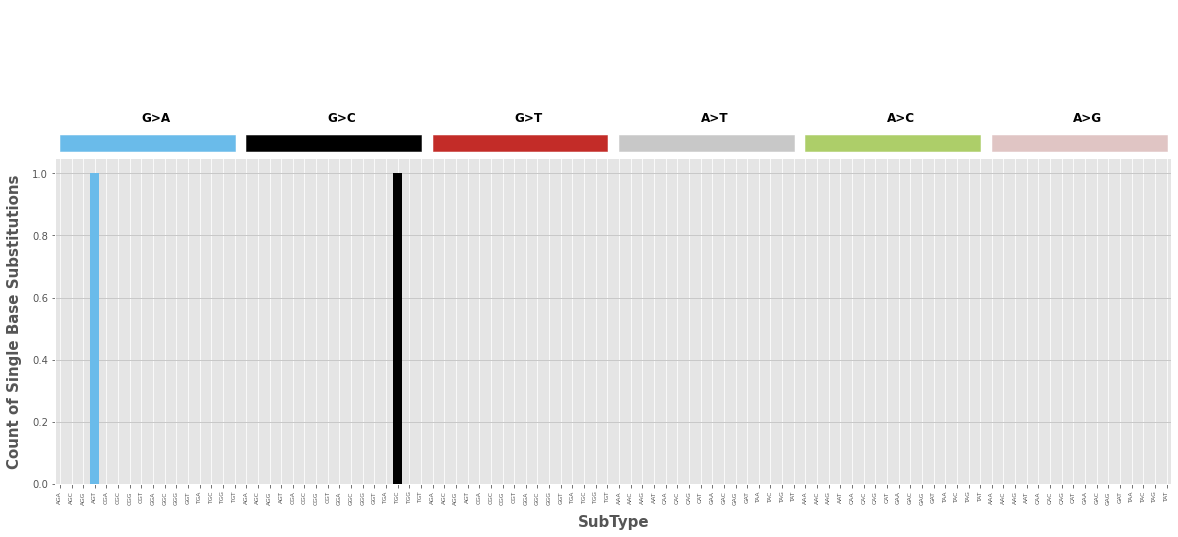

In [36]:
sig_plot(clade="O", base_type="purine", aaf_limit=0.005)

Example: Visualize the variant bases in Clade O sequences with an alternate allele frequency of 0.5% and with a pyrimidine reference base.

11 alternate SNPs included out of a total of 1186 SNPs
0 identified SNPs do not match reference base!
9 total SNPs sorted into SBS-192 classification scheme


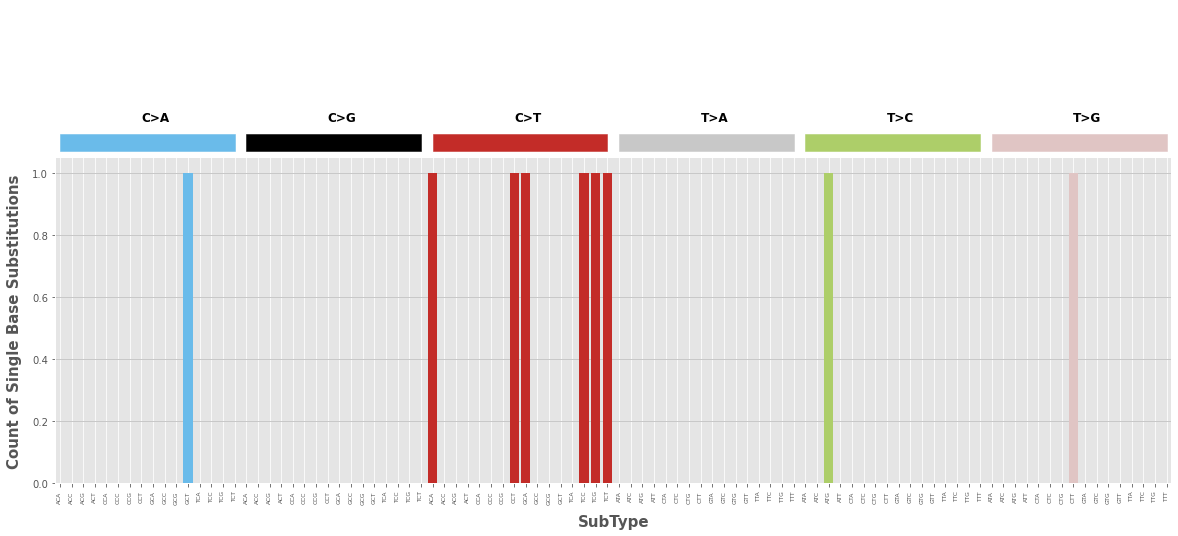

In [37]:
sig_plot(clade="O", base_type="pyrimidine", aaf_limit=0.005)

# Search for all variants in a clade with a substitution at a specific genomic position

In [49]:
def variant_search_position(clade, position):
    data_vcf = read_vcf(clade)
    sample = data_vcf[data_vcf["POS"] == position].loc[:, "NC_045512.2":]
    sample = sample.replace(0, np.nan)
    return sample.dropna(how="all", axis=1).columns.tolist()
    

Example: What sequence from Clade O has a variant at position 1002?

In [50]:
variant_search_position(clade="O", position=1002)

['hCoV-19/SaudiArabia/KAUST-JEDDAH1014/2020|EPI_ISL_512885|2020-06-17']

# Search for all variants in a clade with a specific reference to alternate base substitution 

In [53]:
def variant_search_base(clade, ref_base, alt_base):
    data_vcf = read_vcf(clade)
    sample = data_vcf[data_vcf["REF"] == ref_base]
    sample = data_vcf[data_vcf["ALT"] == alt_base].loc[:, "NC_045512.2":]
    sample = sample.replace(0, np.nan)
    return sample.dropna(how="all", axis=1).columns.tolist()

Example: What sequence from Clade O has a reference base of G and alternate base of A?

In [54]:
variant_search_base(clade="O", ref_base="G", alt_base="A")

['hCoV-19/Australia/NSW14/2020|EPI_ISL_413600|2020-03-03',
 'hCoV-19/Australia/VIC123/2020|EPI_ISL_419731|2020-03-20',
 'hCoV-19/Australia/VIC30/2020|EPI_ISL_419749|2020-03-10',
 'hCoV-19/India/UN-1073/2020|EPI_ISL_421662|2020-03-10',
 'hCoV-19/India/UN-1093/2020|EPI_ISL_421663|2020-03-10',
 'hCoV-19/India/UN-1100/2020|EPI_ISL_421664|2020-03-10',
 'hCoV-19/India/UN-1104/2020|EPI_ISL_421665|2020-03-10',
 'hCoV-19/India/UN-1111/2020|EPI_ISL_421666|2020-03-10',
 'hCoV-19/India/UN-1115/2020|EPI_ISL_421667|2020-03-10',
 'hCoV-19/India/UN-1125/2020|EPI_ISL_421668|2020-03-10',
 'hCoV-19/India/UN-1616/2020|EPI_ISL_421669|2020-03-12',
 'hCoV-19/India/UN-1617/2020|EPI_ISL_421670|2020-03-12',
 'hCoV-19/India/UN-1621/2020|EPI_ISL_421671|2020-03-12',
 'hCoV-19/India/UN-1644/2020|EPI_ISL_421672|2020-03-12',
 'hCoV-19/USA/WI-UW-183/2020|EPI_ISL_428279|2020-03-22',
 'hCoV-19/Sri',
 'hCoV-19/Thailand/Bangkok-0039/2020|EPI_ISL_429175|2020-03-28',
 'hCoV-19/Australia/VIC1210/2020|EPI_ISL_430500|2020-04-0

# Search for top n variants with the highest mutation burden

In [57]:
def variant_search_top_n(clade, top_n):
    data_vcf = read_vcf(clade)
    return data_vcf.loc[:, "NC_045512.2":].sum(axis=0).nlargest(top_n)

Example: Return the top n sequences from Clade O with the highest total variant burden

In [58]:
variant_search_top_n(clade="O", top_n=10)

hCoV-19/India/HR-IMT-CB130/2020|EPI_ISL_547592|2020-08-27      9
hCoV-19/England/MILK-800527/2020|EPI_ISL_557185|2020-07-16     9
hCoV-19/Australia/NSW1123/2020|EPI_ISL_593737|2020-09-13       9
hCoV-19/Shenzhen/SZTH-001/2020|EPI_ISL_406592|2020-01-13       8
hCoV-19/England/LOND-1250707/2020|EPI_ISL_665228|2020-10-25    8
hCoV-19/England/LOND-1250AC2/2020|EPI_ISL_665244|2020-11-02    8
hCoV-19/India/UT-AR37/2020|EPI_ISL_511910|2020-05-28           7
hCoV-19/England/QEUH-9994AD/2020|EPI_ISL_559763|2020-08-24     7
hCoV-19/USA/GA-CDC-4459/2020|EPI_ISL_576190|2020-09-11         7
hCoV-19/Canada/MB-NML-1150/2020|EPI_ISL_582477|2020-07-19      7
dtype: int64

# Rainfall Plot Visualization with NC_045512 COVID-19 Reference Genome Annotation Map

In [68]:
def rainfall_plot(clade, aaf_limit):

    filtered_df = filter_vcf(clade, aaf_limit = aaf_limit)

    filtered_distance = [1]
    for i in range(1, len(filtered_df)):
        filtered_distance.append(filtered_df.iloc[i,0] - filtered_df.iloc[i-1,0])

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(filtered_df["position"], filtered_distance, c='r')
    ax.set_yscale("log")
    ax.set_xlim([0, 30000])
    ax.set_ylim([1, 100000])
    ax.set_title("Rainfall Plot", pad=200)
    ax.set_xlabel("Genomic Position", labelpad=10)
    ax.set_ylabel("Genomic Distance", labelpad=10)

    ax.text(6700, 120000, "ORF1ab", horizontalalignment='center', verticalalignment='center', rotation=0)
    ax.add_patch(patches.Rectangle((266, 99999),13217,50000,linewidth=1,edgecolor='black',facecolor='white', label="ORF1ab", clip_on=False))
    ax.text(400, 280000, "nsp1", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((1, 150000),805,50000,linewidth=1,edgecolor='black',facecolor='black', label="nsp1", clip_on=False))
    ax.text(1762, 280000, "nsp2", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((806, 150000),1913,50000,linewidth=1,edgecolor='black',facecolor='none', label="nsp2", clip_on=False))
    ax.text(5600, 280000, "nsp3", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((2720, 150000),5834,50000,linewidth=1,edgecolor='black',facecolor='black', label="nsp3", clip_on=False))
    ax.text(9300, 280000, "nsp4", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((8555, 150000),1499,50000,linewidth=1,edgecolor='black',facecolor='none', label="nsp4", clip_on=False))
    ax.text(10500, 280000, "nsp5", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((10055, 150000),917,50000,linewidth=1,edgecolor='black',facecolor='black', label="nsp5", clip_on=False))
    ax.text(11400, 280000, "nsp6", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((10973, 150000),869,50000,linewidth=1,edgecolor='black',facecolor='none', label="nsp6", clip_on=False))
    ax.text(12100, 280000, "nsp7", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((11843, 150000),248,50000,linewidth=1,edgecolor='black',facecolor='black', label="nsp7", clip_on=False))
    ax.text(12500, 280000, "nsp8", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((12092, 150000),593,50000,linewidth=1,edgecolor='black',facecolor='none', label="nsp8", clip_on=False))
    ax.text(12950, 280000, "nsp9", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((12686, 150000),338,50000,linewidth=1,edgecolor='black',facecolor='black', label="nsp9", clip_on=False))
    ax.text(13400, 280000, "nsp10", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((13025, 150000),416,50000,linewidth=1,edgecolor='black',facecolor='none', label="nsp10", clip_on=False))
    ax.text(13750, 280000, "nsp11", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((13442, 150000),38,50000,linewidth=1,edgecolor='black',facecolor='black', label="nsp11", clip_on=False))

    ax.text(18500, 230000, "3'to 5' exonuclease", rotation=45)
    ax.add_patch(patches.Rectangle((18040, 150000),1580,50000,linewidth=1,edgecolor='black',facecolor='none', label="3'to 5' exonuclease", clip_on=False))
    ax.text(20000, 230000, "EndoRNAse", rotation=45)
    ax.add_patch(patches.Rectangle((19621, 150000),1037,50000,linewidth=1,edgecolor='black',facecolor='black', label="EndoRNAse", clip_on=False))
    ax.text(21000, 230000, "2'-O ribose methyltransferase", rotation=45)
    ax.add_patch(patches.Rectangle((20659, 150000),893,50000,linewidth=1,edgecolor='black',facecolor='none', label="2'-O ribose methyltransferase", clip_on=False))
    ax.text(23400, 230000, "S", rotation=45)
    ax.add_patch(patches.Rectangle((21563, 150000),3821,50000,linewidth=1,edgecolor='black',facecolor='black', label="S", clip_on=False))
    ax.text(25700, 230000, "ORF3a", rotation=45)
    ax.add_patch(patches.Rectangle((25393, 150000),827,50000,linewidth=1,edgecolor='black',facecolor='none', label="ORF3a", clip_on=False))
    ax.text(26300, 230000, "E", rotation=45)
    ax.add_patch(patches.Rectangle((26245, 150000),227,50000,linewidth=1,edgecolor='black',facecolor='black', label="E", clip_on=False))
    ax.text(26800, 230000, "M", rotation=45)
    ax.add_patch(patches.Rectangle((26523, 150000),668,50000,linewidth=1,edgecolor='black',facecolor='none', label="M", clip_on=False))
    ax.text(27100, 230000, "ORF6", rotation=45)
    ax.add_patch(patches.Rectangle((27202, 150000),185,50000,linewidth=1,edgecolor='black',facecolor='black', label="ORF6", clip_on=False))
    ax.text(27450, 230000, "ORF7a", rotation=45)
    ax.add_patch(patches.Rectangle((27394, 150000),365,50000,linewidth=1,edgecolor='black',facecolor='none', label="ORF7a", clip_on=False))
    ax.text(27750, 230000, "ORF7b", rotation=45)
    ax.add_patch(patches.Rectangle((27756, 150000),131,50000,linewidth=1,edgecolor='black',facecolor='black', label="ORF7b", clip_on=False))
    ax.text(28100, 230000, "ORF8", rotation=45)
    ax.add_patch(patches.Rectangle((27894, 150000),365,50000,linewidth=1,edgecolor='black',facecolor='none', label="ORF8", clip_on=False))
    ax.text(28900, 230000, "N", rotation=45)
    ax.add_patch(patches.Rectangle((28274, 150000),1259,50000,linewidth=1,edgecolor='black',facecolor='black', label="N", clip_on=False))
    ax.text(29400, 230000, "ORF10", rotation=45)
    ax.add_patch(patches.Rectangle((29558, 150000),116,50000,linewidth=1,edgecolor='black',facecolor='none', label="ORF10", clip_on=False))
    ax.text(29800, 230000, "3' UTR", rotation=45)
    ax.add_patch(patches.Rectangle((29675, 150000),228,50000,linewidth=1,edgecolor='black',facecolor='black', label="3' UTR", clip_on=False))


Example: Visualize the variant bases in Clade O sequences with an alternate allele frequency of 0.5% as a rainfall plot with X-axis as genomic position and Y-axis as log scaled genomic distance from previous variant location

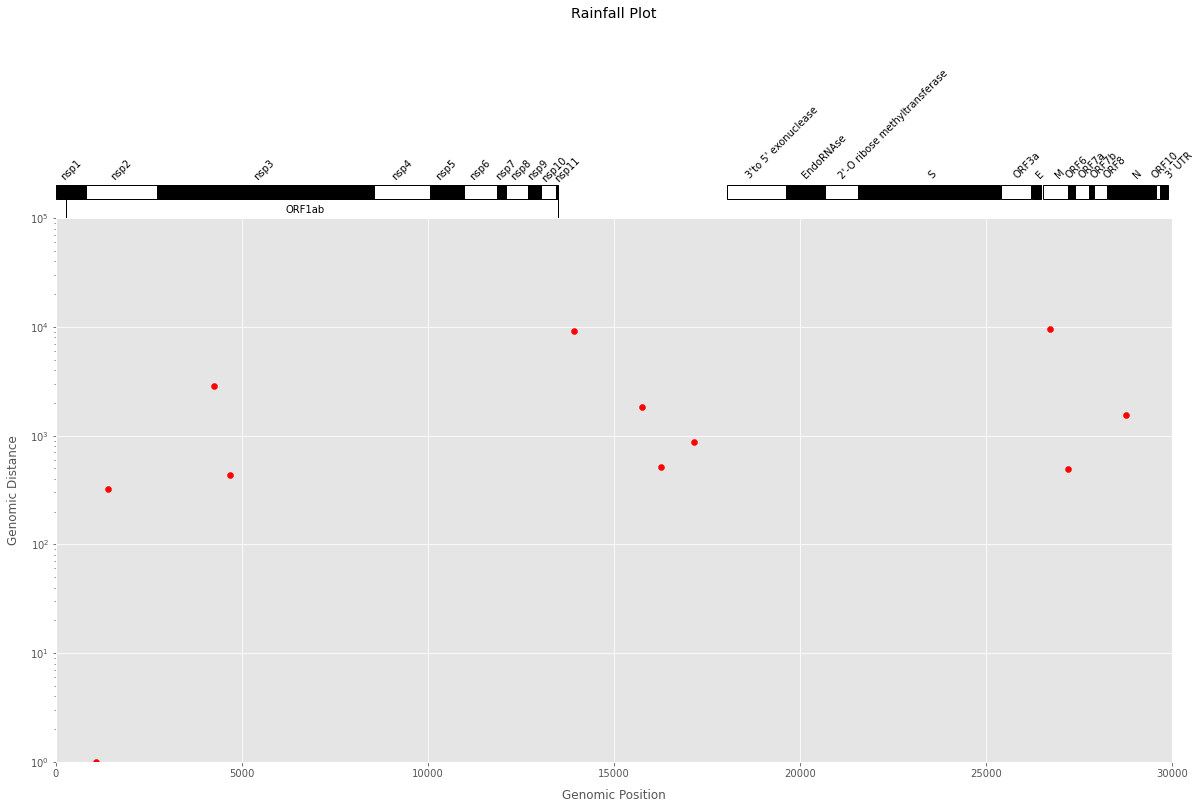

In [69]:
rainfall_plot(clade="O", aaf_limit=0.005)